## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Read in the dataset and take a look at the top few rows.

In [2]:
# Load dataset and display the first 5 rows.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset.

In [3]:
# Find the total number of rows.
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
# Find the number of unique users
df['user_id'].nunique()

290584

The proportion of users converted.

In [5]:
# Find the proportion of users converted
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Create a string to find the number of rows with 
#   landing_page : new page, group : control
#   landing_page : old page, group : treatment

query_string = '(landing_page=="new_page" & group=="control")'
query_string += ' | '
query_string += '(landing_page=="old_page" & group=="treatment")' 

query_string

'(landing_page=="new_page" & group=="control") | (landing_page=="old_page" & group=="treatment")'

In [7]:
# Find the number of rows where new_page and treatment don't line up.
df.query(query_string).user_id.count()

3893

Do any of the rows have missing values?

In [8]:
# Find if there is any row missing values.
df.isnull().sum().any()

False

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page.

In [9]:
# Create a string to filter out rows that do not align with correct test settings.
# The rows will be kept if 
#   landing_page : new page, group : control
#   landing_page : old page, group : treatment

query_string = '(landing_page=="new_page" & group=="treatment")'
query_string += ' | '
query_string += '(landing_page=="old_page" & group=="control")' 

# Create new dataframe df2 with rows with correst test settings.
df2 = df.query(query_string)

In [10]:
# Reset the index
df2.reset_index(inplace=True)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique user_ids?

In [12]:
# Find the number of unique users in df2
df2['user_id'].nunique()

290584

There is one duplicated user_id.

In [13]:
# Find the duplicated user_id in df2
df2_duplicated = df2[df2['user_id'].duplicated()==True]

# Make sure there is only one duplicated user_id 
df2_duplicated.shape[0]

1

In [14]:
# Information for duplicated user_id 
df2_duplicated.iloc[0]

index                                 2893
user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2862, dtype: object

In [15]:
# Duplicated user_id in df2
df2_duplicated.iloc[0]['user_id']

773192

What is the row information for the repeat user_id? 

In [16]:
# Find the index of duplicated user_id in df2
df2_duplicated_index = df2_duplicated.index.get_values()[0]
df2_duplicated_index

2862

Remove one of the rows with a duplicate user_id.

In [17]:
# Number of rows in df2
df2.shape[0]

290585

In [18]:
# Drop the row of duplicated user_id by index
df2 = df2.drop(df.index[df2_duplicated_index])

# Make sure there is only one row dropped
df2.shape[0]

290584

In [19]:
# Make sure there is no more duplicate user_id
df2['user_id'].duplicated().sum()

0

What is the probability of an individual converting regardless of the page they receive?

In [20]:
# Find conversion probability
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
# Find conversion probability for control group
df2.query('group=="control"').converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
# Find conversion probability for treatment group
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [23]:
# Find probability for displaying new page
# Can be found by:
#     Number of new page displayed / Total number of tests
df2.query('landing_page=="new_page"').user_id.count()/df2.shape[0]

0.5000619442226688

I believe there is no strong evidence to tell whether old or new page leads to more conversions.  The conversion rate for the old page is slightly better than the new page, but not by much.  The difference is only 0.00158 (0.12039 - 0.11881).

<a id='ab_test'></a>
### Part II - A/B Test

Define null hypothesis and alternative hypothesis.

**Null Hypothesis - The conversion rate of new pages is less or equal to the conversion rate of old pages.**
$$ H_0: P_{new} \leq P_{old} $$
<br/><br/>

**Alternative Hypothesis: - The conversion rate of new pages is greater to the conversion rate of old pages at a Type I error rate of 5%.**
$$ H_1: P_{new} > P_{old} $$ <br/>


Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page. 

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.  

What is the convert rate for $p_{new}$ under the null? 

In [24]:
# From question above "assume they are equal to the converted rate 
# in ab_data.csv regardless of the page."
# Find the conversion rate of all data
p_new = df2['converted'].mean()
p_new

0.11959708724499628

What is the convert rate for $p_{old}$ under the null?

In [25]:
# The conversion rate for Pold is the same as Pnew.
# See above comment.
p_old = p_new
p_old

0.11959708724499628

What is $n_{new}$?

In [26]:
# Find new_page counts in data
n_new = df2.query('landing_page=="new_page"').user_id.count()
n_new

145310

What is $n_{old}$?

In [27]:
# Find old_page counts in data
n_old = df2.query('landing_page=="old_page"').user_id.count()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [28]:
# Simulating n_new transaction with a convert rate of p_new with 0's and 1's
new_page_converted = np.random.binomial(1, p_new, n_new)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [29]:
# Simulating p_old transaction with a convert rate of p_old with 0's and 1's
old_page_converted = np.random.binomial(1, p_old, n_old)

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
# Find the difference in conversion rate between 2 two pages
new_page_converted.mean() - old_page_converted.mean()

0.002427513055955413

Simulate 10,000 $p_{new}$ - $p_{old}$ values.

In [31]:
p_diffs = []

# Perform the sampling distribution for the difference in conversion rate
# between the two pages over 10,000 trails.
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [32]:
# Convert to numpy array
p_diffs = np.array(p_diffs)
p_diffs.size

10000

Plot a histogram of the p_diffs.

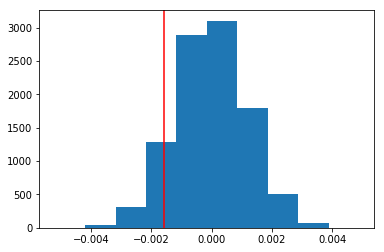

In [33]:
# Plot distribution
plt.hist(p_diffs)

# Calculate observed difference
obs_diff = df2.query('group=="treatment"').converted.mean() - df2.query('group=="control"').converted.mean()

# Plot line for observed difference
plt.axvline(obs_diff, c='red')

What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [34]:
# Compute the p-value by finding the proportion of values in the null 
# distribution that were greater than our observed difference.
(p_diffs > obs_diff).mean()

0.9031

The value computed in part j is called "p-value" in scientific studies. The p-value is the probability of getting our statistic (or a more extreme value) if the null is true. When the p-value is large, which in this case, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null.

Also the p-value is greater than Type I Error (p-value 0.9062 > alpha 0.05), thus we fail to reject the null.

This means that the conversion rate of new pages are slightly less than the conversion rate of old pages.

Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
# Import stasmodels api
import statsmodels.api as sm

# Number of sucesses in trials for old and new pages
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# Number of trials for old and new pages
n_old = df2.shape[0] - df2.query("landing_page == 'new_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

C:\Users\ayumi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Use stats.proportions_ztest to compute the test statistic and p-value.

In [36]:
# Calculating z_score and p_value using stats.proportions_ztest()
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('{0:0.3f}'.format(z_score))
print('{0:0.3f}'.format(p_value))

1.311
0.905


The z-score is our deviation from the mean in units of standard deviation. It cannot to be used to tell explicitly whether we accept or reject our null hypothesis.

The p-value is the probability of getting our statistic (or a more extreme value) if the null is true. When the p-value is large, which in this case, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null.

Also the p-value is greater than Type I Error (p-value 0.905 > alpha 0.05), thus we fail to reject the null. 

I got the p-value of 0.9062 from sampling distributions (question 2.j) which matches closely to the p-value 0.905 I got from proportions_ztest (question 2.m). The finding from previous question that we fail to reject the null agrees with question 2.k also.

<a id='regression'></a>
### Part III - A regression approach

The result I acheived in the previous A/B test can also be acheived by performing regression.

I will be peforming Logistic Regression since I am predicting 0 (no conversion) or 1 (conversion).

In [37]:
# Add an intercept column
df2['intercept'] = 1

# Create dummy variable columns for group
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


Use statsmodels to import the regression model.

In [38]:
# Drop column 'control' as I am using it as baseline
df2 = df2.drop('control', axis=1)
df2.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,treatment
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [39]:
# Instantiate the Logistic Regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])

# Fit the model
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Display the summary.

In [41]:
# Workaround the error "module 'scipy.stats' has no attribute 'chisqprob'"
# https://github.com/statsmodels/statsmodels/issues/3931
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Display the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:12:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The alternative hypothesis for Logistic Regression is two-sided test where as it was one-sided test for Part II.  So here null and alternative hypotheses are:

**Null Hypothesis - The conversion rate of new pages is equal to the conversion rate of old pages.**
$$ H_0: P_{new} = P_{old} $$
<br/>

**Alternative Hypothesis: - The conversion rate of new pages is not equal to the conversion rate of old pages at a Type I error rate of 5%.**
$$ H_1: P_{new} \neq P_{old} $$ 
<br/>

The p-value I got from Logistic Regression is 0.190 which doesn't match with p-value 0.9062 and 0.905 I got from the distribution sampling and proportions_ztest, respectively.  I would think this is expected as p-value for Logistic Regression is for two-sided test and the others were for one-sided test.


**Knowing that Part iii is a two-tailed test and Part ii is a one-tail test, can I convert the p-values between each other?**

According to the resource I found (below), "Depending on the direction of the one-tailed hypothesis, its p-value is either 0.5\*(two-tailed p-value) or 1-0.5\*(two-tailed p-value) if the test statistic symmetrically distributed about zero."

I can calculate one-tailed p-value from two-tailed p-value by<br/>
0.5\*0.190 = 0.095 or 1-(0.5\*0.190) = 0.905 ---> Matches with proportions_ztest p-value.

Or I can calculate two-tailed p-value from one-tailed p-value by<br/>
0.095/0.5 = 0.19 or (1-0.905)/0.5 = 0.19 ---> Matches with Logistic Regression p-value.


Resource: This is the [webpage](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/) I got information about how to covert p-value between one-tail and two-tailed tests.



**Why it is a good idea to consider other factors to add into your regression model?  Are there any disadvantages to adding additional terms into your regression model?**

The other things that might influence whether or not an individual converts and might consider adding into the regression models are: 
* How long the experiement run?  Could the existing users bias results in short time frame?
* Were they all new users or did the test include existing users?  The existing users might needed to adjust to the change.
* Was the conversion rate alone not the best metric?  Was revenue needed to be accounted for?
* Did the experiement have enough trafic to produce significant and repeatable results in this time frame?

The disadvantage of adding additional terms into the regression model is that there might be a chance multicollinearity exists. We would like explanatory variables to be related to the response, but not to be related to one another.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. Does it appear that country had an impact on conversion?

In [42]:
# Load country info of users.
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Check df2 info before joining country data
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 8 columns):
index           290584 non-null int64
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
treatment       290584 non-null uint8
dtypes: int64(4), object(3), uint8(1)
memory usage: 18.0+ MB


In [44]:
# Merge df2 and df_country by user_id
df_combined = df2.join(df_country.set_index( ['user_id'], verify_integrity=True), on=['user_id'], how='left')

# Make sure new df_combined looks ok, total rows, non-null, etc.
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 9 columns):
index           290584 non-null int64
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
treatment       290584 non-null uint8
country         290584 non-null object
dtypes: int64(4), object(4), uint8(1)
memory usage: 20.2+ MB


Look at an interaction between page and country to see if there significant effects on conversion. 

In [45]:
# Get avariable countries
df_combined['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [46]:
# Add an intercept column
df_combined['intercept'] = 1

# Create dummy variable columns for group
df_combined[['CA', 'UK', 'US']] = pd.get_dummies(df_combined['country'])
df_combined.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,CA,UK,US
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [47]:
# Drop column 'US' as I am using it as baseline
df_combined = df_combined.drop('US', axis=1)
df_combined.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,CA,UK
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [48]:
# Instantiate the Logistic Regression model
log_mod = sm.Logit(df_combined['converted'], df_combined[['intercept', 'treatment', 'CA', 'UK']])

# Fit the model
results = log_mod.fit()

# Display the summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:12:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [49]:
# Exponentiate coefficient of each explanatory variables to interpret the result
(np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099))

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

In [50]:
# Computing the reciprocal as treatment and CA multiplicative changes are less than 1. 
(1/np.exp(-0.0149), 1/np.exp(-0.0408))

(1.0150115583846535, 1.0416437559600236)

Conversion happens 1.0150 times less likely for treatment than control holding all else constant.<br/>
Conversion happens 1.0416 times less likey for users living in CA than US holding all else constant.<br/>
Conversion happens 1.0099 times likey for users living in UK than US holding all else constant.

None of explanatory variables' p-value suggest that they are statistically significant.

With the result above, it appears that country had no impact on conversion.

### Conclusions
> From the result of sampling distributions, built-in function proportions_ztest,<br/>
and logistic regression, there is no strong evidence that new page generate<br/>
more conversion. <br/><br/>

> Also looking at an interaction between page and country, there is no significant<br/>
effects on conversion, either.<br/><br/>

> For reasons above, I would suggest that it is not worth spending time and money to<br/>
create and launch new page.